# BetaVAE on CARS196 dataset

The <a href="https://www.tensorflow.org/datasets/catalog/cars196">cars196</a> dataset contains 16,185 images of 196 different types of cars, which
can be used to train a supervised learning system to determine the make and model of a vehicle in a photograph.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import model
from model import *

/opt/anaconda3/envs/NN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
beta = 1.2
height, width, depth = 128, 192, 1
batch_size = 32
pad = 10 # padding for cropping
filters = [64,32,16]
latent_dim = 10
image_size = (height, width, depth)
last_convdims = (int(height/(2**(len(filters)))),
                 int(width/(2**(len(filters)))))
epochs = 20

Let's get the data. Working on your machine, change `download` to `True` and change `DATA_DIR` to the name of the local directory you want to download the data to.

In [3]:
DATA_DIR = './cars196'

[train_ds, test_ds], ds_info = tfds.load(
    "cars196",
    # Reserve 10% for validation and 50% for test
    split=["train", "test"],
    as_supervised=True,  # Include labels
    with_info=True,
    download=True,
    data_dir=DATA_DIR,
)

In [4]:
tr_ds = train_ds.map(lambda x, y: x)
te_ds = test_ds.map(lambda x, y: x)
ds = tr_ds.concatenate(te_ds)
ds

<ConcatenateDataset shapes: (None, None, 3), types: tf.uint8>

In [8]:
ds = ds.map(lambda x: tf.clip_by_value(x,0,255)) #make sure you have no color value higher than 225 or lower than 0.

## Resize images

In [9]:
resized_ds = ds.map(lambda x: (tf.image.resize(x, (height, width))))
resized_ds

<MapDataset shapes: (128, 192, 3), types: tf.float32>

## Random data augmentation

Let's the data and use caching and prefetching to optimize load speed:

In [10]:
flipped_ds = resized_ds.map(lambda x: tf.image.random_flip_left_right(x))
flipped_ds

<MapDataset shapes: (128, 192, 3), types: tf.float32>

In [16]:
def cropper(image):
    image = tf.image.resize_with_crop_or_pad(image, 2*height, 2*width)
    image = tf.image.random_crop(image, size=[height, width, 3])
    image = tf.cast(image, dtype='float32')
    return image

cropped_ds = ds.cache().map(cropper)
cropped_ds

<MapDataset shapes: (128, 192, 3), types: tf.float32>

In [18]:
big_ds = resized_ds.concatenate(flipped_ds)
big_ds

<ConcatenateDataset shapes: (128, 192, 3), types: tf.float32>

In [20]:
contrasted_ds = big_ds.map(lambda x: tf.image.random_contrast(x,1,2))
contrasted_ds

<MapDataset shapes: (128, 192, 3), types: tf.float32>

In [21]:
bigger_ds = big_ds.concatenate(cropped_ds)
bigger_ds

<ConcatenateDataset shapes: (128, 192, 3), types: tf.float32>

In [22]:
final_ds = bigger_ds.concatenate(contrasted_ds)
final_ds

<ConcatenateDataset shapes: (128, 192, 3), types: tf.float32>

## RGB to BW

In [23]:
final_bw_ds = final_ds.map(lambda x: (tf.image.rgb_to_grayscale(x)))
final_bw_ds

<MapDataset shapes: (128, 192, 1), types: tf.float32>

## Normalize images
Pixel values from range (0,255) to range (0,1)

In [24]:
norm_bw_ds = final_bw_ds.map(lambda x: x / 255.) # tf.expand_dims(x,axis=0)
norm_bw_ds

<MapDataset shapes: (128, 192, 1), types: tf.float32>

In [26]:
dataset = norm_bw_ds.shuffle(100).batch(batch_size).prefetch(buffer_size=10)
dataset

<PrefetchDataset shapes: (None, 128, 192, 1), types: tf.float32>

Let's visualize what the first 18 images of the first batch looks like after various random transformations.

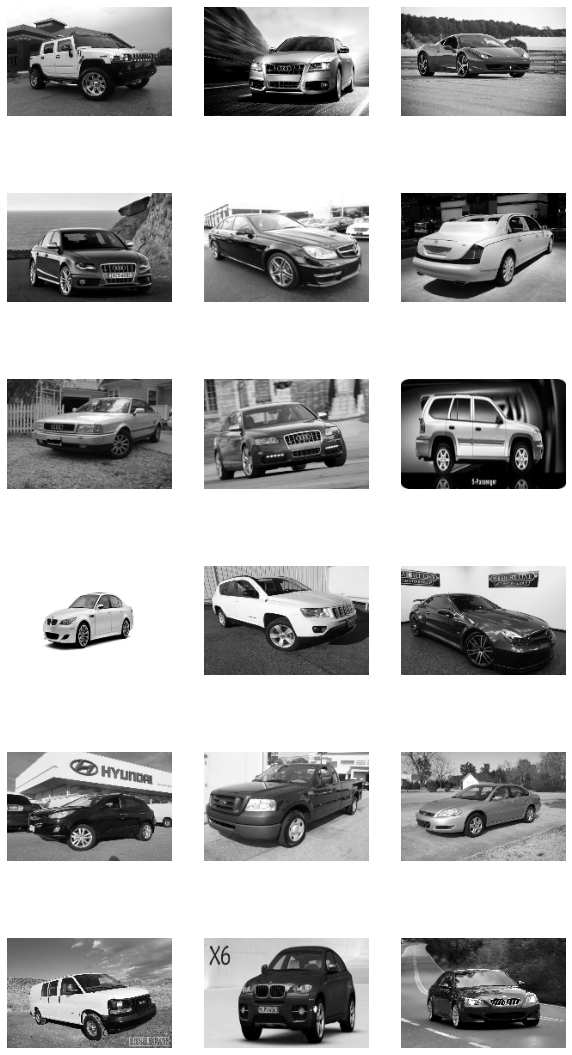

In [27]:
plt.figure(figsize=(10, 20))
for i, image_batch in enumerate(dataset.take(18)): # we did batch(batch_size) before, if we didn't, "take" will take individual image.
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(image_batch[0,:,:,:].numpy(),cmap='binary_r')
        plt.axis("off")


## Build a model

In [28]:
encoder10 = Encoder(filters=filters,latent_dim=latent_dim,image_shape=image_size)
encoder10.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 192, 1) 0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (None, 64, 96, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv_norm_1 (BatchNormalization (None, 64, 96, 64)   256         conv_layer_1[0][0]               
__________________________________________________________________________________________________
conv_relu_1 (ReLU)              (None, 64, 96, 64)   0           conv_norm_1[0][0]                
____________________________________________________________________________________________

In [29]:
decoder10 = Decoder(latent_dim=latent_dim,filters=filters,last_convdims=last_convdims, img_depth=depth)
decoder10.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6144)              67584     
_________________________________________________________________
reshape (Reshape)            (None, 16, 24, 16)        0         
_________________________________________________________________
deconv2d_1 (Conv2DTranspose) (None, 32, 48, 16)        2320      
_________________________________________________________________
deconv_norm_1 (BatchNormaliz (None, 32, 48, 16)        64        
_________________________________________________________________
deconv_relu_1 (ReLU)         (None, 32, 48, 16)        0         
_________________________________________________________________
deconv2d_2 (Conv2DTranspose) (None, 64, 96, 32)        4640

In [31]:
vae10 = VAE(encoder10,decoder10,beta=beta)
vae10.compile(optimizer=keras.optimizers.Adam())
vae10.fit(dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/20
2529/2529 [==============================] - 3065s 1s/step - Total_loss: 11171024896.0000 - Reconstruction_loss: 1773571.0000 - KL_loss: 9307703296.0000
Epoch 2/20
2529/2529 [==============================] - 1959s 774ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 3/20
2529/2529 [==============================] - 1925s 761ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 4/20
2529/2529 [==============================] - 1950s 771ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 5/20
2529/2529 [==============================] - 1943s 768ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 6/20
2529/2529 [==============================] - 1944s 768ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 7/20
2529/2529 [==============================] - 1933s 764ms/step - Total_loss: nan - Reconstruction_loss: nan - KL_loss: nan
Epoch 8/20
2529/2529 [================

KeyboardInterrupt: 

In [ ]:
for image_batch in dataset.take(1):
    images = image_batch.numpy()

i = 5
image = images[i,:,:,:]
img = np.expand_dims(image, 0)
vae_model = vae10

In [ ]:
def show_reconstr_hor(image,vae_model):
    img = np.expand_dims(image, 0)
    z_mean,_,_ = vae_model.encoder.predict(img)
    prediction = vae_model.decoder.predict(z_mean)
    plt.rcParams['font.size'] = 15
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    bef_n_aft = [image,prediction[0,:,:,:]]
    titles = ['Initial image','Encoded-Decoded image']
    for i,ax in enumerate(axs.flat):
        ax.imshow(bef_n_aft[i],cmap='binary_r')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

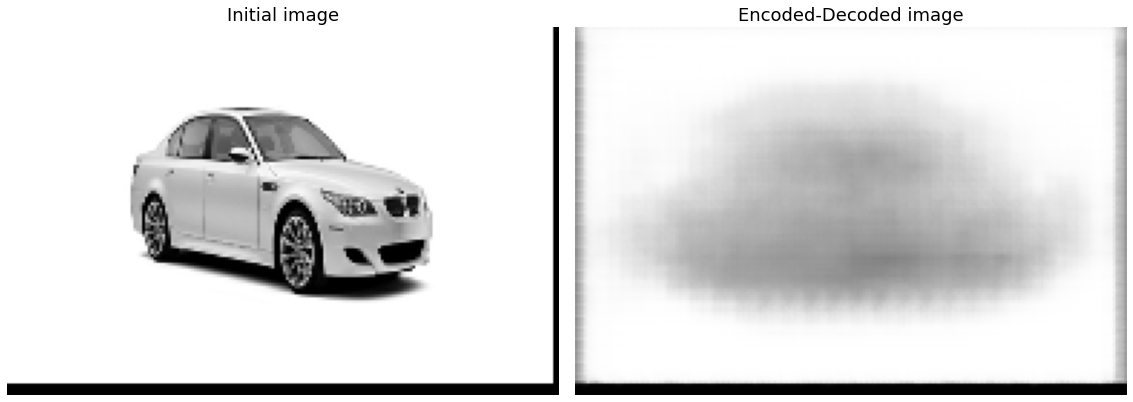

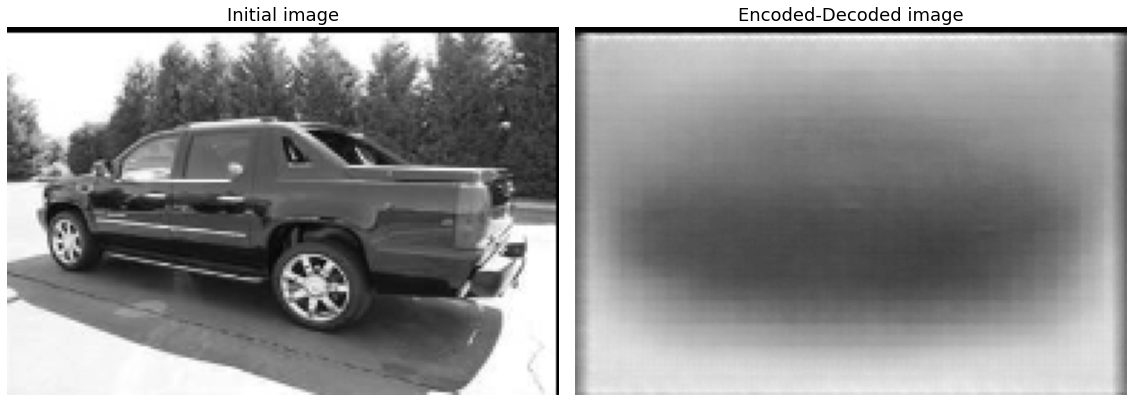

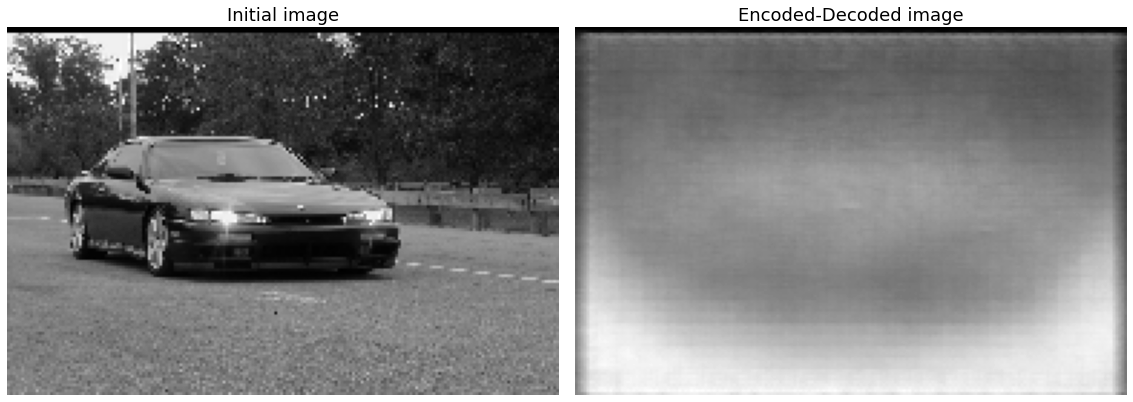

In [ ]:
for i in [10,20,30]:
    show_reconstr_hor(images[i,:,:,:],vae_model)